In [ ]:
import math, re, os
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.8.0


# Configurations

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
# Create strategy from tpu
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)
# Configuration
IMAGE_SIZE = [256, 256]
EPOCHS = 60
BATCH_SIZE = 64 * strategy.num_replicas_in_sync

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
# !gsutil ls gs://thesis_ngoanpv/256x256/

In [ ]:
GCS_PATH = 'gs:/'
TRAINING_FILENAMES = tf.io.gfile.glob('gs://train_fasd*.tfrec') 
TEST_FILENAMES = tf.io.gfile.glob('gs://test_fasd*.tfrec') 

Unhide to see `CLASSES`:

In [ ]:
len(TRAINING_FILENAMES)

128

In [ ]:
CLASSES = [b'0', b'1']                                                                                                                                        # 100 - 102z

## Datasets Functions

In [ ]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image
#dict_keys(['lbp83', 'lbp86', 'lbp82', 'lpq', 'rbg', 'hsv', 'lbp85', 'lbp81', 'lbp84', 'label'])

def read_labeled_tfrecord(example):
    features = {
        'rbg': tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        'lbp81': tf.io.FixedLenSequenceFeature([], tf.float32,allow_missing=True),  # tf.string = bytestring (not text string)
        'lbp82': tf.io.FixedLenSequenceFeature([], tf.float32,allow_missing=True),  # tf.string = bytestring (not text string)
        'lbp83': tf.io.FixedLenSequenceFeature([], tf.float32,allow_missing=True),  # tf.string = bytestring (not text string)
        'lbp84': tf.io.FixedLenSequenceFeature([], tf.float32,allow_missing=True),  # tf.string = bytestring (not text string)
        'lbp85': tf.io.FixedLenSequenceFeature([], tf.float32,allow_missing=True),  # tf.string = bytestring (not text string)
        'lbp86': tf.io.FixedLenSequenceFeature([], tf.float32,allow_missing=True),  # tf.string = bytestring (not text string)
        'lpq': tf.io.FixedLenSequenceFeature([], tf.float32,allow_missing=True),  # tf.string = bytestring (not text string)
        'hsv': tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        'label':         tf.io.FixedLenFeature([], tf.int64),  # one bytestring
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    lbp81 = example['lbp81']
    # FixedLenFeature fields are now ready to use: exmple['size']
    # VarLenFeature fields require additional sparse_to_dense decoding
    
    image = tf.image.decode_jpeg(example['rbg'], channels=3)
    image = tf.reshape(image, [IMAGE_SIZE[0],IMAGE_SIZE[0],3])
    lbp81 = tf.reshape(lbp81, [256,])
    label = tf.cast(example['label'], tf.int32)
    return (image, lbp81), label
  
def read_unlabeled_tfrecord(example):
    features = {
        'rbg': tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        'lbp81': tf.io.FixedLenSequenceFeature([], tf.float32,allow_missing=True),  # tf.string = bytestring (not text string)
        'lbp82': tf.io.FixedLenSequenceFeature([], tf.float32,allow_missing=True),  # tf.string = bytestring (not text string)
        'lbp83': tf.io.FixedLenSequenceFeature([], tf.float32,allow_missing=True),  # tf.string = bytestring (not text string)
        'lbp84': tf.io.FixedLenSequenceFeature([], tf.float32,allow_missing=True),  # tf.string = bytestring (not text string)
        'lbp85': tf.io.FixedLenSequenceFeature([], tf.float32,allow_missing=True),  # tf.string = bytestring (not text string)
        'lbp86': tf.io.FixedLenSequenceFeature([], tf.float32,allow_missing=True),  # tf.string = bytestring (not text string)
        'lpq': tf.io.FixedLenSequenceFeature([], tf.float32,allow_missing=True),  # tf.string = bytestring (not text string)
        'hsv': tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        'label':         tf.io.FixedLenFeature([], tf.int64),  # one bytestring
    }
    example = tf.io.parse_single_example(example, features)
    
    # FixedLenFeature fields are now ready to use: exmple['size']
    # VarLenFeature fields require additional sparse_to_dense decoding    
    image = tf.image.decode_jpeg(example['rbg'], channels=3)
    # image = tf.reshape(image, [*IMAGE_SIZE, 3])
    label = tf.cast(example['label'], tf.int32)

    return image, -1

def load_dataset(filenames, labeled=True, ordered=True):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    # dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

# def data_augment(image, label, seed=2020):
#     # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
#     # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
#     # of the TPU while the TPU itself is computing gradients.
#     image = tf.image.random_flip_left_right(image, seed=seed)
#     return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    # dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.shuffle(2048)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=True):
    dataset = load_dataset(TEST_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_train_valid_datasets():
    dataset = load_dataset(TRAINING_FILENAMES + VALIDATION_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [ ]:
def read_only_label(example):
    features = {
        'label': tf.io.FixedLenFeature([], tf.int64),  # one bytestring
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    # FixedLenFeature fields are now ready to use: exmple['size']
    # VarLenFeature fields require additional sparse_to_dense decoding
    
    label = tf.cast(example['label'], tf.int32)
    # print(label)
    # label = label.numpy()
    return label
def m(a):
  return a.numpy() 

def load_label_val(filenames, labeled=True, ordered=True):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    # dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_only_label, num_parallel_calls=AUTO)
    # dataset = dataset.map(m, num_parallel_calls=AUTO)

    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

In [ ]:
label_val = load_label_val(TEST_FILENAMES)

In [ ]:
label_val_list = list(label_val)

In [ ]:
len(label_val_list)

65790

In [ ]:
label_val_list = [a.numpy() for a in label_val_list]

# Training Model

In [ ]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print('Dataset: {} training images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_TEST_IMAGES))

Dataset: 45085 training images, 65790 unlabeled test images


In [ ]:
from PIL import Image

In [ ]:
def display_9_images_from_dataset(dataset):
    plt.figure(figsize=(13,13))
    subplot=331
    for i, (image, label) in enumerate(dataset):
        plt.subplot(subplot)
        plt.axis('off')
        plt.imshow(image.numpy().astype(np.uint8))
        plt.title(label.numpy(), fontsize=16)
        subplot += 1
        if i==8:
            break
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

In [ ]:
def read_labeled_tfrecord_example(example):
    features = {
        'rbg': tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring
        'hsv': tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        'label': tf.io.FixedLenFeature([], tf.int64),  # one bytestring
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    # FixedLenFeature fields are now ready to use: exmple['size']
    # VarLenFeature fields require additional sparse_to_dense decoding
    
    lbp83 = example['hsv']
    image = tf.image.decode_jpeg(example['rbg'], channels=3)
    image = tf.reshape(image, [IMAGE_SIZE[0],IMAGE_SIZE[0],3])
    label = tf.cast(example['label'], tf.int32)
    return image, lbp83, label

def load_dataset_example(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord_example, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def get_training_dataset_example():
    dataset = load_dataset_example(TRAINING_FILENAMES, labeled=True)
    # dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.shuffle(2048)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

In [ ]:
data_train = get_training_dataset()

In [ ]:
data_train

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 256, 256, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 256), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
image_sample, label_sample = None, None
for i, ((image_sample, lbp81),label_sample) in enumerate(data_train):
  image_sample, lbp81, label_sample = image_sample,lbp81,label_sample
  break

In [ ]:
import tensorflow as tf 
import json
from google.protobuf.json_format import MessageToJson
raw_dataset = tf.data.TFRecordDataset('gs://thesis_ngoanpv/256x256/train_siw_00-943.tfrec')

m = None
for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    m = json.loads(MessageToJson(example))
    print(m['features']['feature'].keys())
    break

dict_keys(['lbp84', 'lbp82', 'rbg', 'label', 'lpq', 'lbp85', 'hsv', 'lbp81', 'lbp86', 'lbp83'])


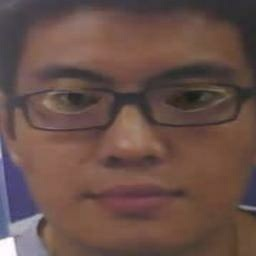

In [ ]:
from PIL import Image
Image.fromarray(image_sample.numpy()[10,:,:], 'RGB')

## Load Model into TPU

## Training

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        preprocessing.RandomFlip(mode='horizontal', seed=1996), 
    ],
    name="img_augmentation",
)

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
NUM_CLASSES = 2
IMG_SIZE = 256

In [ ]:
def create_model():
  inputs_image = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
  # inputs_image = img_augmentation(inputs_image)
  resnet_model = ResNet50(include_top=False, input_tensor=inputs_image, weights="imagenet")
  resnet_model.trainable = True
  x = layers.GlobalAveragePooling2D(name="avg_pool")(resnet_model.output)
  x = layers.BatchNormalization()(x)
  outputs = layers.Dense(512)(x)
  model_image = tf.keras.Model(inputs_image, outputs, name="model_image")

  input_lbp = layers.Input(shape=(256))
  lbp_model = Sequential(
      [
      layers.Dense(512, activation="relu"), 
      layers.BatchNormalization(),
      layers.Dense(256), 
      ]
  )
  lbp_model(input_lbp)

  combined = layers.concatenate([model_image.output, lbp_model.output])
  # apply a FC layer and then a regression prediction on the
  # combined outputs
  z = layers.Dense(1024, activation="relu")(combined)
  z = layers.Dense(512, activation="relu")(z)
  top_dropout_rate = 0.05
  z = layers.Dropout(top_dropout_rate, name="top_dropout")(z)
  z = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(z)

  # our model will accept the inputs of the two branches and
  # then output a single value
  model = tf.keras.Model(inputs=[model_image.input, lbp_model.input], outputs=z)

  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
  model.compile(
          optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy']
      )
  
  return model

In [ ]:
with strategy.scope():
  model = create_model()

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
checkpoint_filepath = "gs://thesis_ngoanpv/result_fasd_lbp81"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
history = model.fit(
    get_training_dataset(), 
    validation_data = get_validation_dataset(),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=60, 
    callbacks=[early_stop, model_checkpoint_callback]
)

Epoch 1/60
88/88 [==============================] - 127s 737ms/step - loss: 0.0180 - accuracy: 0.9919 - val_loss: 0.2060 - val_accuracy: 0.9230
Epoch 2/60
88/88 [==============================] - 50s 571ms/step - loss: 9.4574e-04 - accuracy: 0.9996 - val_loss: 0.1850 - val_accuracy: 0.9532
Epoch 3/60
88/88 [==============================] - 51s 580ms/step - loss: 4.2881e-04 - accuracy: 0.9999 - val_loss: 0.1547 - val_accuracy: 0.9643
Epoch 4/60
88/88 [==============================] - 51s 577ms/step - loss: 4.2457e-04 - accuracy: 0.9999 - val_loss: 0.1098 - val_accuracy: 0.9707
Epoch 5/60
88/88 [==============================] - 46s 521ms/step - loss: 5.1619e-04 - accuracy: 0.9998 - val_loss: 0.1120 - val_accuracy: 0.9705
Epoch 6/60
88/88 [==============================] - 53s 602ms/step - loss: 2.1391e-04 - accuracy: 0.9999 - val_loss: 0.1239 - val_accuracy: 0.9744
Epoch 7/60
88/88 [==============================] - 46s 520ms/step - loss: 7.4387e-05 - accuracy: 1.0000 - val_loss: 0.14

In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
val_dataset = get_validation_dataset()

In [ ]:
model.evaluate(val_dataset)

129/129 [==============================] - 19s 130ms/step - loss: 0.1021 - accuracy: 0.9794


[0.10207531601190567, 0.9794497489929199]

In [ ]:
model_result = model.predict(val_dataset)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save_weights('/content/drive/MyDrive/thesis/resnet50LBP_81/fasd_acc09794_dropout005.h5')

In [ ]:
model_result[:, 1]

array([1.8149673e-05, 3.4290310e-03, 3.3690140e-01, ..., 8.2781672e-01,
       9.9961889e-01, 7.8431576e-01], dtype=float32)

In [ ]:
spoof_result = model_result[:, 1]

In [ ]:
spoof_result.shape

(65790,)

In [ ]:
import pandas as pd
df = pd.read_csv('/content/meta_fasd_test (1).csv')

In [ ]:
df.label

0        1
1        1
2        1
3        1
4        1
        ..
65785    0
65786    0
65787    0
65788    0
65789    0
Name: label, Length: 65790, dtype: int64

In [ ]:
label_val_list[4]

In [ ]:
label_val_arr = np.asarray(label_val_list)

In [ ]:
import numpy as np
import sys
import copy
from sklearn.metrics import roc_curve, auc
from scipy import interp

def get_err_threhold(fpr, tpr, threshold):
    RightIndex=(tpr+(1-fpr)-1)
    right_index = np.argmax(RightIndex)
    best_th = threshold[right_index]
    err = fpr[right_index]
    differ_tpr_fpr_1=tpr+fpr-1.0
    right_index = np.argmin(np.abs(differ_tpr_fpr_1))
    best_th = threshold[right_index]
    err = fpr[right_index]

    return err, best_th
def performances(test_scores, test_labels):
    # print('label',test_labels)
    # print('score',test_scores)

    test_labels_bk = copy.deepcopy(test_labels)
    test_scores_bk = copy.deepcopy(test_scores)
    test_labels_bk[test_labels_bk < 0] = 0

    fpr_test, tpr_test, threshold_test = roc_curve(test_labels_bk, test_scores_bk, pos_label=1)
    err, best_th = get_err_threhold(fpr_test, tpr_test, threshold_test)
    precision_th1 = 0.005
    RECALL1 = interp(precision_th1, fpr_test, tpr_test)

    precision_th2 = 0.01
    RECALL2 = interp(precision_th2, fpr_test, tpr_test)

    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(test_labels.shape[0]):
        if test_labels[i] == 0:
            if test_scores[i] <= best_th:
                TP += 1
            else:
                FN += 1
        else:
            if test_scores[i] > best_th:
                TN += 1
            else:
                FP += 1
    print(f'TP = {TP}, FP = {FP}, TN = {TN}, FN = {FN}')

    FAR = FP / (FP + TP + 0.000001)  ### False Acceptance Rate
    FRR = FN / (TN + FN + 0.000001)  ### False Rejection Rate
    
    HTER = (FAR + FRR) / 2  ### Half Total Error Rate
    APCER = FP / (TN + FP + 0.000001)  ### Attack Presentation Classification Error Rate
    TNR = 1 - APCER  ### True Negative Rate
    NPCER = FN / (FN + TP + 0.000001)  ### Normal Presentation Classification Error Rate
    TPR = 1 - NPCER  ### True Positive Rate
    ACER = (APCER + NPCER) / 2  ### Average Classification Error Rate
    ACC = (TP + TN) / (0.000001 + TP + FP + FN + TN)

    return np.float32(FAR), np.float32(FRR), np.float32(HTER), np.float32(APCER), \
           np.float32(TNR), np.float32(NPCER), np.float32(TPR), np.float32(ACER), np.float32(ACC), np.float32(best_th)

In [ ]:
performances(spoof_result, label_val_arr)

TP = 15495, FP = 1306, TN = 48574, FN = 415


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


(0.077733465,
 0.00847129,
 0.04310238,
 0.02618284,
 0.97381717,
 0.026084224,
 0.97391576,
 0.026133532,
 0.973841,
 0.977959)